# Non model based

In [70]:
import os
import re
import math
from copy import deepcopy
from itertools import chain
from string import punctuation
from operator import itemgetter

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
here = os.getcwd()
project_path = os.path.dirname(here)
data_path = os.path.join(project_path, "data", "session_speech.csv")

In [4]:
data = pd.read_csv(data_path, converters={"speech":eval})
data.columns

Index(['name', 'vote', 'speech'], dtype='object')

In [5]:
data.shape

(70, 3)

In [8]:
data = data.explode(column="speech")
data.head()

,name,vote,speech
0,Ana Claudia Almirón,positivo,"Hace dos años, tuvimos una sesión histórica cu..."
1,Roberto Gustavo Basualdo,negativo,"Gracias, señor presidente. Hoy es un día en el..."
2,Pablo Daniel Blanco,negativo,Como voy a pedir la inserción de mis argumento...
3,Inés Imelda Blas,negativo,"Gracias, presidenta. Nuevamente, nos encontram..."
4,Néstor Braillard Poccard,negativo,"Gracias, señora presidenta. Realmente, como di..."


In [10]:
data.speech.isna().sum()

9

In [13]:
data.vote.isin(["abstención", "ausente"]).sum()

3

In [19]:
data[(data.speech.isna()) | (data.vote.isin(["abstención", "ausente"]))].shape

(11, 3)

In [20]:
data = data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
data.shape

(199, 3)

In [76]:
def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(rf"[{punctuation}\“\”\¿\¡\−\…]", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [77]:
data["speech_prep"] = data.speech.apply(preprocess)
data.head()

,name,vote,speech,speech_prep
0,Ana Claudia Almirón,positivo,"Hace dos años, tuvimos una sesión histórica cu...",hace dos años tuvimos una sesión histórica cua...
1,Roberto Gustavo Basualdo,negativo,"Gracias, señor presidente. Hoy es un día en el...",gracias señor presidente hoy es un día en el q...
2,Pablo Daniel Blanco,negativo,Como voy a pedir la inserción de mis argumento...,como voy a pedir la inserción de mis argumento...
3,Inés Imelda Blas,negativo,"Gracias, presidenta. Nuevamente, nos encontram...",gracias presidenta nuevamente nos encontramos ...
4,Néstor Braillard Poccard,negativo,"Gracias, señora presidenta. Realmente, como di...",gracias señora presidenta realmente como dijer...


## Difference of frequencies

In [78]:
data.speech_prep.apply(lambda x: len(list(filter(lambda z: z=="la", x.split()))))

0      64
1       9
2      69
3      65
4      56
     ... 
67     63
68    155
68      0
68      7
69     23
Name: speech_prep, Length: 199, dtype: int64

In [79]:
vectorizer = CountVectorizer(lowercase=True)
X = vectorizer.fit_transform(data.speech_prep)
X = X.toarray()
frequencies = (
    pd
    .DataFrame(
        X, columns=vectorizer.get_feature_names_out(), index=data["vote"]
    )
    .rename_axis("senator_vote", axis=0)
    .reset_index()
    .groupby("senator_vote")
    .sum()
)
frequencies

,abajo,abandonada,abandonadas,abandonar,abandono,abarca,abdominales,aberración,aberrante,aberrantes,...,último,últimos,única,únicamente,únicas,único,únicos,útero,úteros,útil
senator_vote,,,,,,,,,,,,,,,,,,,,,
negativo,1,0,0,1,1,2,0,1,0,1,...,8,2,4,0,0,5,1,3,0,1
positivo,1,1,1,0,0,0,1,0,1,0,...,10,9,8,1,3,7,1,3,1,0


In [80]:
count_total = frequencies.sum(axis=0)
count_difference = frequencies.loc["positivo"]-frequencies.loc["negativo"]
count_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": count_difference,
        "pos": frequencies.loc["positivo"],
        "neg": frequencies.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
count_diff.head()

,word,total,diff,pos,neg
0,abajo,2,0,1,1
1,abandonada,1,1,1,0
2,abandonadas,1,1,1,0
3,abandonar,1,-1,0,1
4,abandono,1,-1,0,1


## Difference of proportions

In [81]:
proportions = frequencies.div(frequencies.sum(axis=1), axis=0)
proportions_difference = proportions.loc["positivo"]-proportions.loc["negativo"]
proportions_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_difference,
        "pos": proportions.loc["positivo"],
        "neg": proportions.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_diff.head()

,word,total,diff,pos,neg
0,abajo,2,-0.000016,0.000019,0.000035
1,abandonada,1,0.000019,0.000019,0.000000
2,abandonadas,1,0.000019,0.000019,0.000000
3,abandonar,1,-0.000035,0.000000,0.000035
4,abandono,1,-0.000035,0.000000,0.000035


## Correction: removing stop words

In [82]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/macarena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [83]:
stw = stopwords.words("spanish")
print(stw)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [90]:
len(stw)

313

In [91]:
stw = list(filter(lambda x: x in frequencies.columns,stw))
len(stw)

192

In [99]:
columns_wo_stw = sorted(set(frequencies.columns).difference(set(stw)))

In [100]:
len(frequencies.columns)

8050

In [102]:
frequencies_wo_stw = frequencies[columns_wo_stw]
len(frequencies_wo_stw.columns)

7858

In [103]:
frequencies_wo_stw

,abajo,abandonada,abandonadas,abandonar,abandono,abarca,abdominales,aberración,aberrante,aberrantes,...,último,últimos,única,únicamente,únicas,único,únicos,útero,úteros,útil
senator_vote,,,,,,,,,,,,,,,,,,,,,
negativo,1,0,0,1,1,2,0,1,0,1,...,8,2,4,0,0,5,1,3,0,1
positivo,1,1,1,0,0,0,1,0,1,0,...,10,9,8,1,3,7,1,3,1,0


In [104]:
proportions_wo_stw = frequencies_wo_stw.div(frequencies_wo_stw.sum(axis=1), axis=0)
proportions_wo_stw_difference = proportions_wo_stw.loc["positivo"]-proportions_wo_stw.loc["negativo"]
proportions_wo_stw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_wo_stw_difference,
        "pos": proportions_wo_stw.loc["positivo"],
        "neg": proportions_wo_stw.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_wo_stw_diff.head()

,word,total,diff,pos,neg
0,abajo,2,-0.000032,0.000038,0.00007
1,abandonada,1,0.000038,0.000038,0.00000
2,abandonadas,1,0.000038,0.000038,0.00000
3,abandonar,1,-0.000070,0.000000,0.00007
4,abandono,1,-0.000070,0.000000,0.00007


## Odds

In [127]:
odds_pos = frequencies.loc["positivo"]/(1-frequencies.loc["positivo"])
odds_neg = frequencies.loc["negativo"]/(1-frequencies.loc["negativo"])
odds_difference = odds_pos/odds_neg
odds_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": odds_difference,
        "pos": odds_pos,
        "neg": odds_neg
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
odds_diff.head()

,word,total,diff,pos,neg
0,abajo,2,NaN,inf,inf
1,abandonada,1,inf,inf,0.0
2,abandonadas,1,inf,inf,0.0
3,abandonar,1,0.0,0.0,inf
4,abandono,1,0.0,0.0,inf


In [144]:
odds_diff["diff"].isin([math.inf, -math.inf]).sum()

3822

In [159]:
def postprocess_odds(row):
    infs = [math.inf, -math.inf]
    if (row.pos in infs) and (row.neg) in infs:
        if row.pos == row.neg:
            return 1
        else:
            return -1
    else:
        return row["diff"]

In [161]:
odds_diff["diff"] = odds_diff.apply(lambda x: postprocess_odds(x), axis=1)
odds_diff

,word,total,diff,pos,neg
0,abajo,2,1.000000,inf,inf
1,abandonada,1,inf,inf,0.00
2,abandonadas,1,inf,inf,0.00
3,abandonar,1,0.000000,0.000000,inf
4,abandono,1,0.000000,0.000000,inf
...,...,...,...,...,...
8045,único,12,0.933333,-1.166667,-1.25
8046,únicos,2,1.000000,inf,inf
8047,útero,6,1.000000,-1.500000,-1.50
8048,úteros,1,inf,inf,0.00


## Log-odds-ratio

Agregar suavizado, pero cuidado: no se puede agregar peso sin más a una frecuencia (la suma ya no va a dar 1).

In [164]:
log_odds_diff = deepcopy(odds_diff)
log_odds_diff["diff"] = np.log(log_odds_diff["diff"])
log_odds_diff.head()

/home/macarena/.pyenv/versions/3.11.4/envs/eddc-spec/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/macarena/.pyenv/versions/3.11.4/envs/eddc-spec/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,word,total,diff,pos,neg
0,abajo,2,0.0,inf,inf
1,abandonada,1,inf,inf,0.0
2,abandonadas,1,inf,inf,0.0
3,abandonar,1,-inf,0.0,inf
4,abandono,1,-inf,0.0,inf


In [16]:
# agregar peso a las frecuencias
smooth_log_odds_diff = deepcopy(odds_diff)
smooth_log_odds_diff["diff"] = smooth_log_odds_diff["diff"].apply(
    lambda x: np.log(x+0.5) if x==0 else np.log(x)
)
smooth_log_odds_diff.head()

,word,total,diff,pos,neg
0,abajo,2,0.000000,1.0,1.0
1,abandonada,1,inf,inf,0.0
2,abandonadas,1,inf,inf,0.0
3,abandonar,1,-0.693147,0.0,inf
4,abandono,1,-0.693147,0.0,inf


## Correction: elimating low-frequency words

In [17]:
low_freq_df = pd.melt(
    smooth_log_odds_diff[["word","pos","neg","diff"]],
    id_vars=["word"],
    value_vars=["diff","pos", "neg"],
)
(
    low_freq_df
    [~low_freq_df["value"].isin([-math.inf, math.inf])]
    .groupby("variable")["value"]
    .agg(
        min="min",
        q5=lambda x: np.percentile(x, q = 5),
        median="median",
        mean="mean",
        std="std",
        q95=lambda x: np.percentile(x, q = 95),
        max="max"
    )
)

,min,q5,median,mean,std,q95,max
variable,,,,,,,
diff,-5.835541,-1.386294,-0.693147,0.139336,1.452970,3.008155,6.182085
neg,0.000000,0.000000,0.000000,0.403668,0.829555,2.000000,18.500000
pos,0.000000,0.000000,0.500000,1.190504,1.911290,4.500000,22.000000


In [18]:
(
    low_freq_df[
        ((low_freq_df["variable"]=="diff") & ((-2.5<=low_freq_df["value"]) & (low_freq_df["value"]<=2.5))) |
        ((low_freq_df["variable"]=="pos") & ((0<=low_freq_df["value"]) & (low_freq_df["value"]<=3))) |
        ((low_freq_df["variable"]=="neg") & ((0<=low_freq_df["value"]) & (low_freq_df["value"]<=0.35)))
    ]
    .groupby("variable")["value"]
    .agg(
        perc=lambda x: round((len(x)/len(smooth_log_odds_diff))*100,2)
    )
)

,perc
variable,
diff,49.95
neg,51.66
pos,50.32


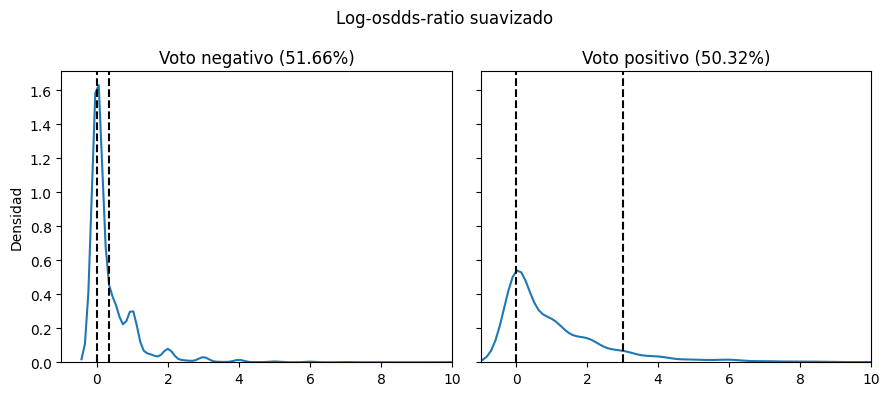

In [19]:
axs_data = {
    "neg": {"xmin": 0, "xmax": 0.35, "title": "Voto negativo", "%": 51.66},
    "pos": {"xmin": 0, "xmax": 3, "title": "Voto positivo", "%": 50.32}
}
fig, axs = plt.subplots(1,2, figsize=(9,4), sharey=True)
for i, key in enumerate(sorted(list(axs_data.keys()))):
    xmin, xmax = itemgetter(*["xmin", "xmax"])(axs_data[key])
    sns.kdeplot(
        smooth_log_odds_diff[(xmin<=smooth_log_odds_diff[key])|(smooth_log_odds_diff[key]<=xmax)],
        x=key, ax=axs[i]
    )
    ymin, ymax = axs[i].get_ylim()
    axs[i].set_ylim(ymin, ymax)
    axs[i].set_xlim(-1, 10)
    axs[i].vlines(x=[xmin, xmax], ymin=ymin, ymax=ymax, linestyles="dashed", color="black")
    axs[i].set_ylabel("Densidad")
    axs[i].set_xlabel("")
    axs[i].set_title(f"{axs_data[key]['title']} ({axs_data[key]['%']}%)")
plt.suptitle("Log-osdds-ratio suavizado")
plt.tight_layout()
plt.show()

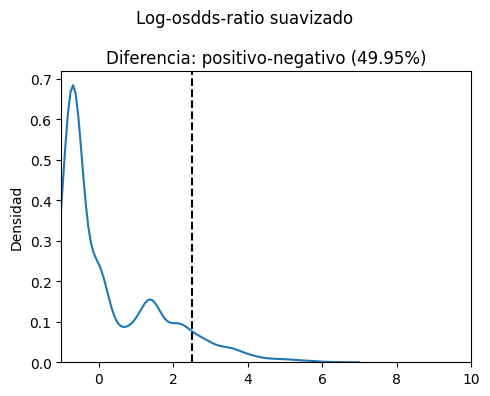

In [20]:
fig, ax = plt.subplots(figsize=(5,4), sharey=True)
xmin, xmax = -2.5, 2.5
sns.kdeplot(
    smooth_log_odds_diff[(xmin<=smooth_log_odds_diff[key])|(smooth_log_odds_diff[key]<=xmax)],
    x="diff", ax=ax
)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax)
ax.set_xlim(-1, 10)
ax.vlines(x=[xmin, xmax], ymin=ymin, ymax=ymax, linestyles="dashed", color="black")
ax.set_ylabel("Densidad")
ax.set_xlabel("")
ax.set_title("Diferencia: positivo-negativo (49.95%)")
plt.suptitle("Log-osdds-ratio suavizado")
plt.tight_layout()
plt.show()

In [21]:
smooth_log_odds_diff_correct_diff = smooth_log_odds_diff[
    (-2.5<=smooth_log_odds_diff["diff"]) & (smooth_log_odds_diff["diff"]<=2.5)
    ]
smooth_log_odds_diff_correct_pos_neg = smooth_log_odds_diff[
    (
        (0<=smooth_log_odds_diff["pos"]) & (smooth_log_odds_diff["pos"]<=3) &
        (0<=smooth_log_odds_diff["neg"]) & (smooth_log_odds_diff["neg"]<=0.35)
    )
]

## TF-IDF

In [22]:
discourses = list(map(lambda x: set(x.split()),data.speech_prep.tolist()))
words = sorted(list(set(chain(*discourses))))

X = np.zeros((len(discourses), len(words)))

for i in range(len(words)):
    for j in range(len(discourses)):
        if words[i] in discourses[j]:
            X[j,i] += 1

df = (
    pd.DataFrame(X, columns=words)
    .filter(frequencies.columns)
    .sum(axis=0)
)
tfidf = proportions*np.log(1/df)
tfidf


,abajo,abandonada,abandonadas,abandonar,abandono,abarca,abdominales,aberración,aberrante,aberrantes,...,último,últimos,única,únicamente,únicas,único,únicos,útero,úteros,útil
senator_vote,,,,,,,,,,,,,,,,,,,,,
negativo,-0.000024,0.0,0.0,0.0,0.0,-0.000048,0.0,0.0,0.0,0.0,...,-0.000711,-0.000160,-0.000319,0.0,-0.000000,-0.000399,-0.000024,-0.000167,0.0,0.0
positivo,-0.000013,0.0,0.0,0.0,0.0,-0.000000,0.0,0.0,0.0,0.0,...,-0.000479,-0.000387,-0.000344,0.0,-0.000062,-0.000301,-0.000013,-0.000090,0.0,0.0


In [23]:
tfidf_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": tfidf.loc["positivo"]-tfidf.loc["negativo"],
        "pos": tfidf.loc["positivo"],
        "neg": tfidf.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
tfidf_diff.head()

,word,total,diff,pos,neg
0,abajo,2,0.000011,-0.000013,-0.000024
1,abandonada,1,0.000000,0.000000,0.000000
2,abandonadas,1,0.000000,0.000000,0.000000
3,abandonar,1,0.000000,0.000000,0.000000
4,abandono,1,0.000000,0.000000,0.000000


In [24]:
corr_prop = tfidf_diff["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

Correlación con proporciones: -0.97


## WordScores

In [25]:
wkw = (
    (proportions.loc["positivo"]-proportions.loc["negativo"])/
    (proportions.loc["positivo"]+proportions.loc["negativo"])
)
nkw = frequencies.sum(axis=0) / frequencies.sum().sum()

wkw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": wkw*nkw,
        "wkw": wkw,
        "nkw": nkw
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
wkw_diff.head()

,word,total,diff,wkw,nkw
0,abajo,2,-0.000007,-0.299228,0.000024
1,abandonada,1,0.000012,1.000000,0.000012
2,abandonadas,1,0.000012,1.000000,0.000012
3,abandonar,1,-0.000012,-1.000000,0.000012
4,abandono,1,-0.000012,-1.000000,0.000012


## Visualizations

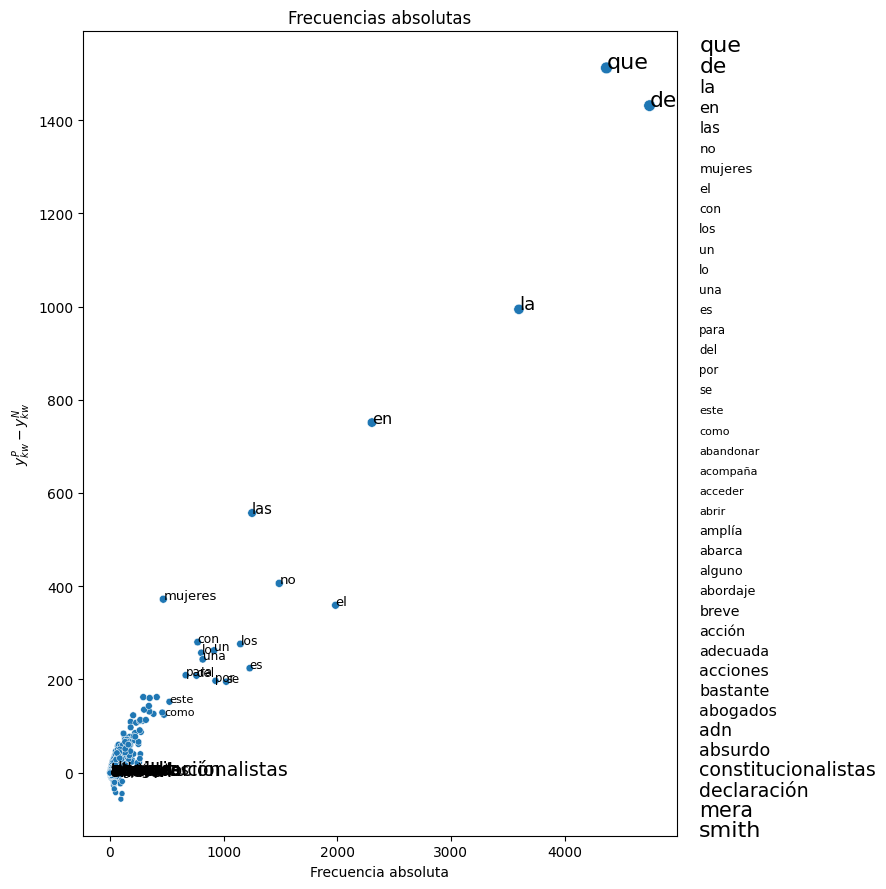

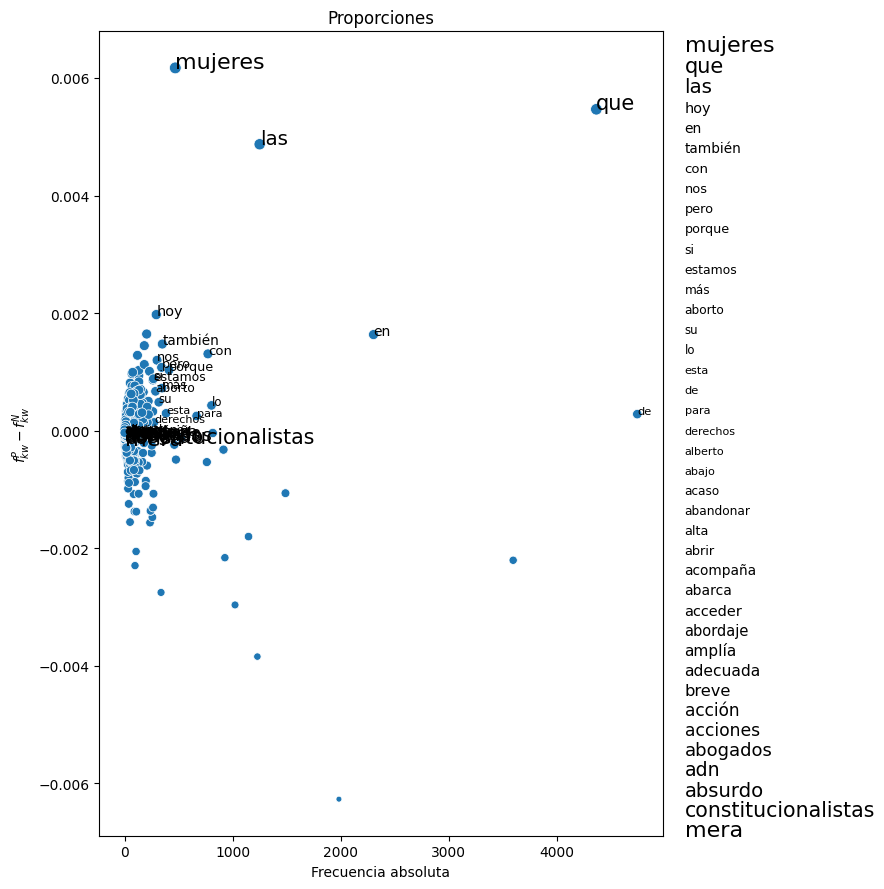

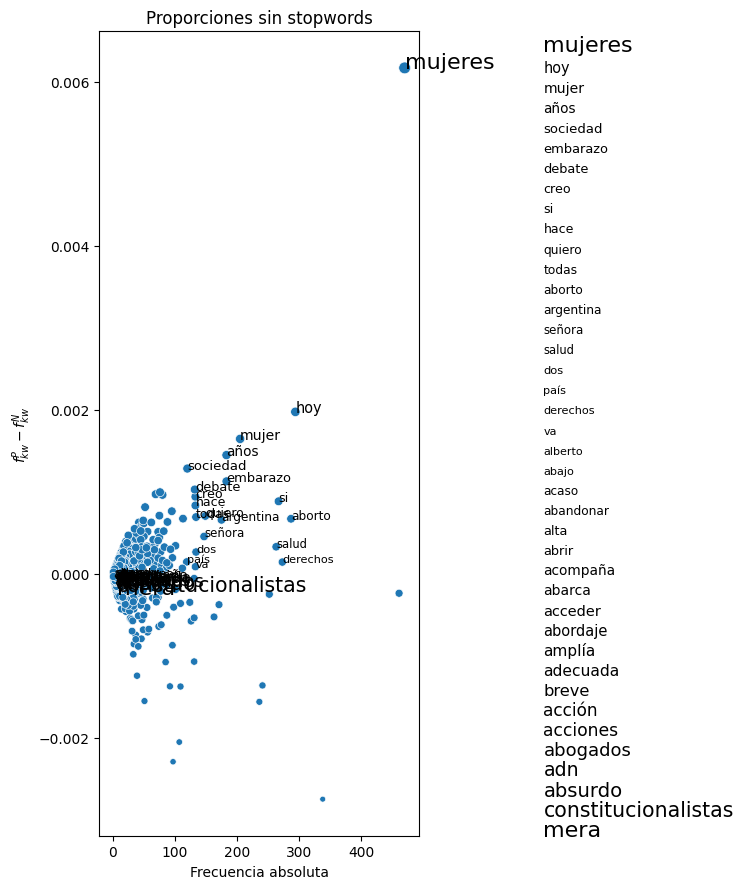

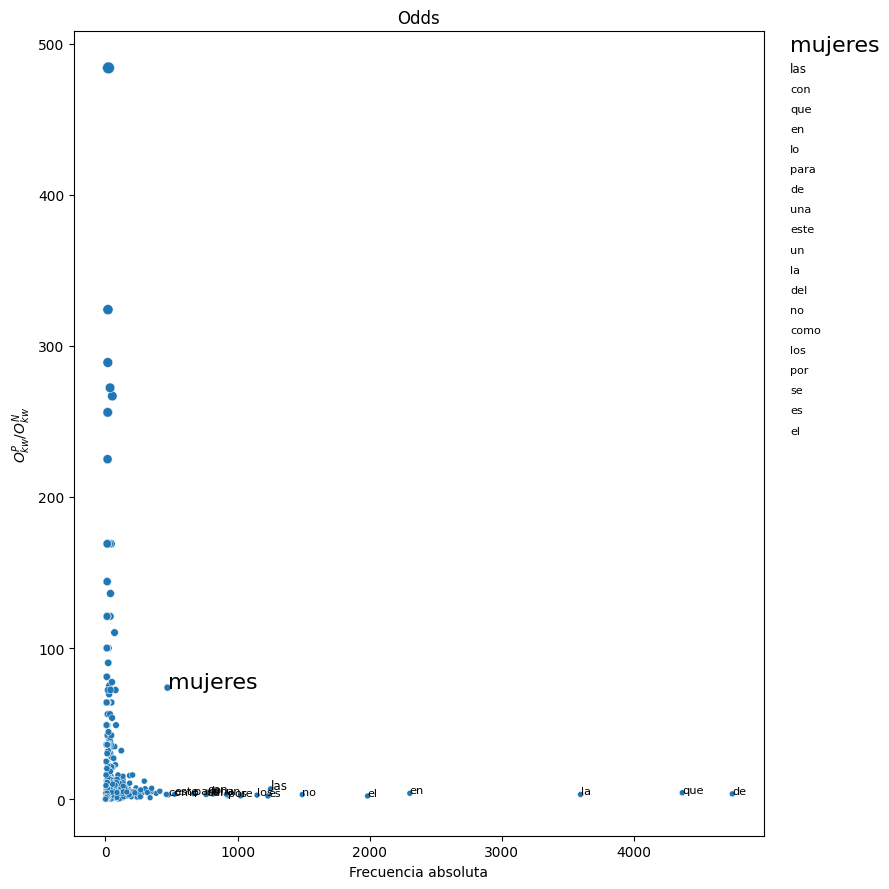

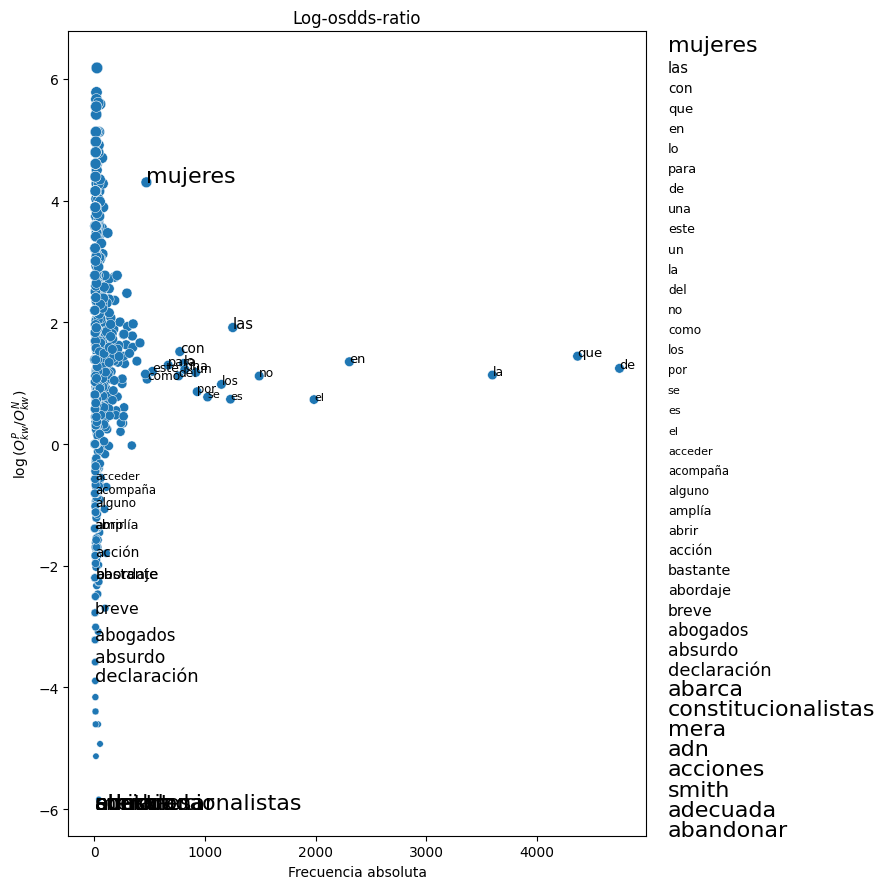

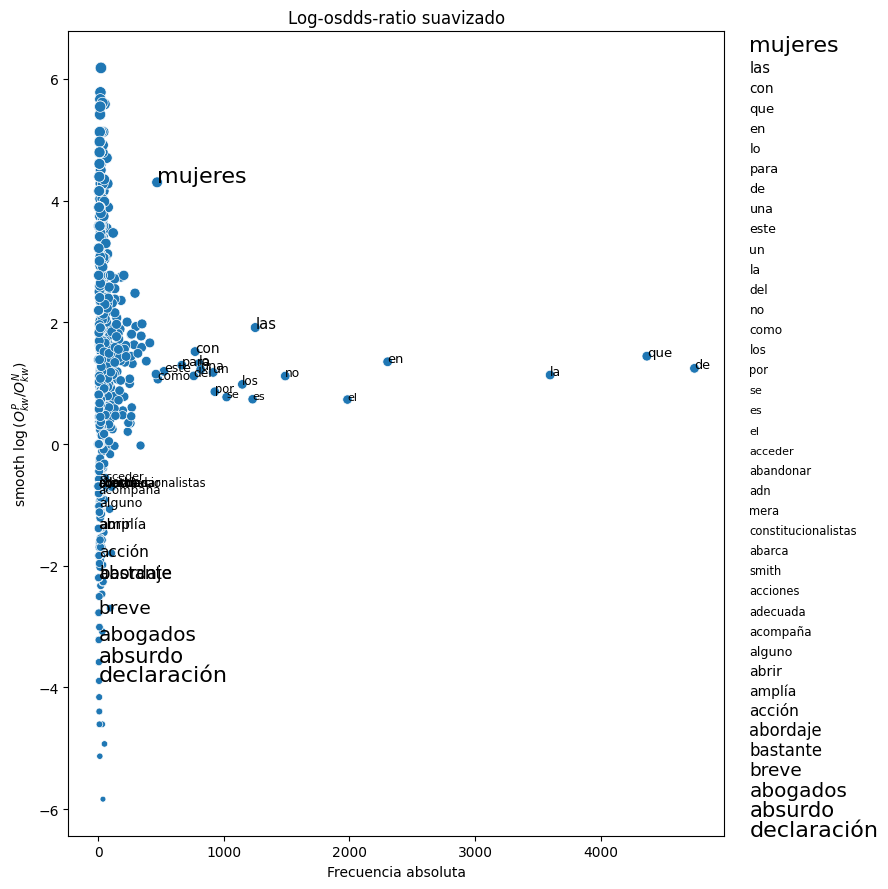

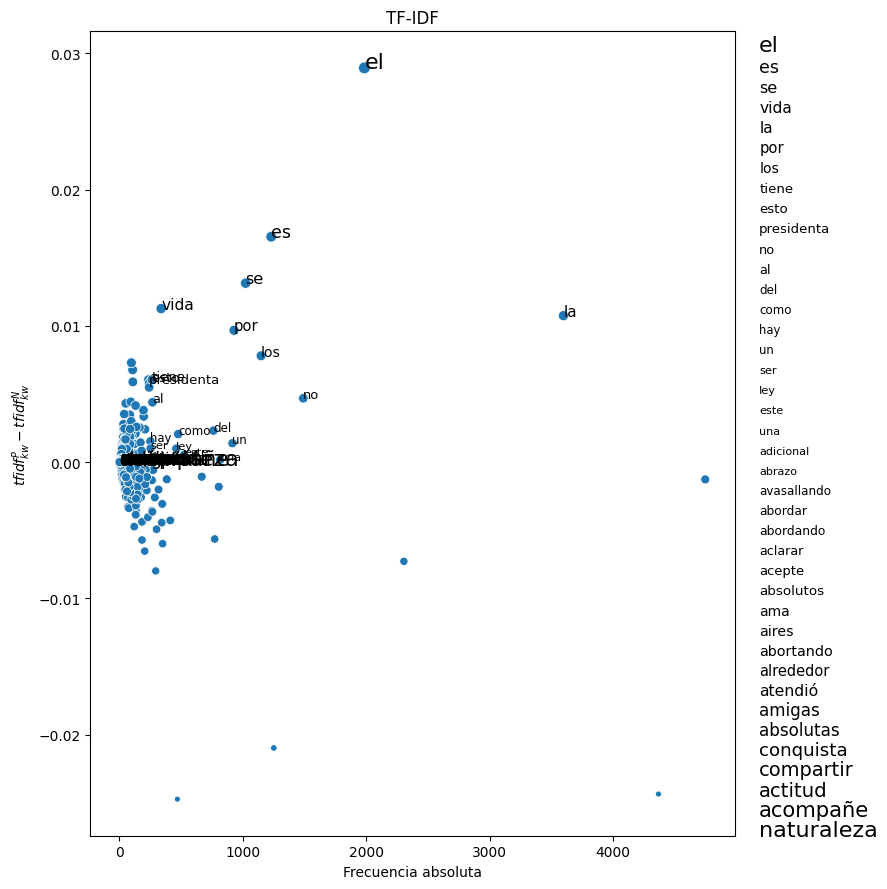

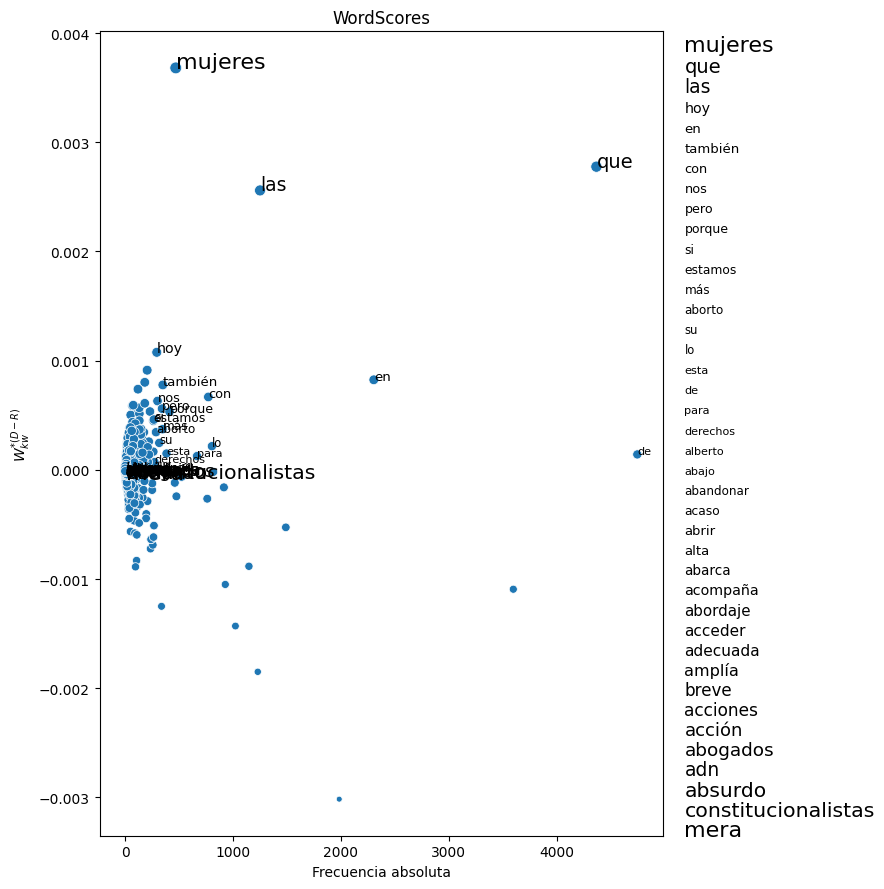

In [26]:
stats = [
    count_diff, proportions_diff, proportions_wo_stopwords, odds_diff,
    log_odds_diff, smooth_log_odds_diff,
    #smooth_log_odds_diff_correct_diff,smooth_log_odds_diff_correct_pos_neg,
    tfidf_diff, wkw_diff
]
titles = [
    "Frecuencias absolutas", "Proporciones", "Proporciones sin stopwords", "Odds",
    "Log-osdds-ratio", "Log-osdds-ratio suavizado",
    #"Log-osdds-ratio suavizado (corrección: differencia)",
    #"Log-osdds-ratio suavizado (corrección: pos y neg)",
    "TF-IDF", "WordScores"
]
y_labels = [
    "$y^{P}_{kw}-y^{N}_{kw}$", "$f^{P}_{kw}-f^{N}_{kw}$", "$f^{P}_{kw}-f^{N}_{kw}$",
    "$O^{P}_{kw}/O^{N}_{kw}$", "$\log{(O^{P}_{kw}/O^{N}_{kw})}$",
    #"smooth $\log{(O^{P}_{kw}/O^{N}_{kw})}$","smooth $\log{(O^{P}_{kw}/O^{N}_{kw})}$",
    "smooth $\log{(O^{P}_{kw}/O^{N}_{kw})}$", "$tfidf^{P}_{kw}-tfidf^{N}_{kw}$",
    "$W^{*(D-R)}_{kw}$"
]
for df, title, y_label in zip(stats,titles,y_labels):
    fig, ax = plt.subplots(figsize=(9,9))
    df_copy = deepcopy(df)
    _max = df_copy["diff"].sort_values().unique().tolist()[-2]
    _min = df_copy["diff"].sort_values().unique().tolist()[2]
    df_copy["size"] = df_copy["diff"].apply(
        lambda x: math.ceil(_max)
        if x==math.inf
        else x
    )
    df_copy["size"] = df_copy["size"].apply(
        lambda x: math.floor(_min)
        if x==-math.inf
        else x
    )
    size_scaler = MinMaxScaler(feature_range=(0.001,1.0))
    dot_size = size_scaler.fit_transform(np.array(df_copy["size"]).reshape(-1,1)).reshape(len(df_copy))
    sns.scatterplot(df_copy, x="total", y="diff", size=dot_size, ax=ax)
    pos = df_copy[df_copy["size"]>0]
    neg = df_copy[df_copy["size"]<0]
    words_scaler = MinMaxScaler(feature_range=(8.0,16.0))
    data = list()
    if not pos.empty:
        pos = (
            pos
            .nlargest(n=20, columns=["total", "size"], keep="first")
            .assign(
                text_size=lambda x: words_scaler.fit_transform(np.array(x["size"]).reshape(-1,1))
            )
            .sort_values(by=["size", "text_size"], ascending=False)
        )
        data.append(pos)
    if not neg.empty:
        neg = (
            neg
            .drop_duplicates(subset=["total", "size"], keep="first")
            .nsmallest(n=20, columns=["total", "size"], keep="first")
            .assign(
                text_size=lambda x: words_scaler.fit_transform(np.array(x["size"]*-1).reshape(-1,1))
            )
            .sort_values(by=["size"], ascending=False)
        )
        data.append(neg)
    words = pd.concat(data)
    for e, (i, row) in enumerate(words.iterrows(), start=1):
        ax.text(
            row["total"], row["size"], row["word"],
            horizontalalignment='left', color='black', fontsize=row["text_size"]
        )
        ylim_min, ylim_max = ax.get_ylim()
        ylim_div = (ylim_max-ylim_min)/40
        ax.text(
            ax.get_xlim()[1]+200, ylim_max-(e*ylim_div), row["word"],
            horizontalalignment='left', color='black', fontsize=row["text_size"]
        )
    ax.set_title(title)
    ax.set_xlabel("Frecuencia absoluta")
    ax.set_ylabel(y_label)
    ax.get_legend().set_visible(False)
    plt.tight_layout()
    filename = title.lower().replace(" ", "_")
    plt.savefig(f"{project_path}/visualizations/stats__{filename}.png")


Ideas:
- en esta nb, hacer las visualizaciones propuestas por el paper para todos los casos
- en la nb de clasificación voy a necesitar features, puedo elegir alguna de estas técnicas visualizando con 
- 

Observaciones:

- en freq. abs. casi no hay palabras negativas, esto puede ser porque:
  - los neg hablaron menos (personas)
  - los neg tienen discursos más breves
  - los neg no usaron palabras que se distingan de pos (en términos de freq. abs.)
  - ... seguir explorando